<a href="https://colab.research.google.com/github/Uzmamushtaque/Projects-in-Machine-Learning-and-AI/blob/main/MNIST_GAN_Training_version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GAN Training
A GAN comprises of a discriminator and a generator. The discriminator classifies data (reduction) and a generator generates (expands) data.
A generative adversarial network (GAN) has two neural networks, a generator and a discriminator, set to compete against each other as adversaries. The discriminator is trained to classify data from a training set as real, and data from the generator as fake. The generator is trained to create data that looks real enough to fool the discriminator.

The standard GAN training loop has three steps:

1. Train the discriminator with a real data example.
2. Train the discriminator with a generated data example.
3. Train the generator to get a correct classification from the discriminator.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


In [2]:
class MnistDataset(Dataset):
  def __init__(self, csv_file):
    self.data_df = pd.read_csv(csv_file)


  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, index):
    # image target (label)
    label = self.data_df.iloc[index,0]
    target = torch.zeros((10))
    target[label] = 1.0

    # image data, normalised from 0-255 to 0-1
    image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0

    # return label, image data tensor and target tensor
    return label, image_values, target

  def plot_image(self, index):
    arr = self.data_df.iloc[index,1:].values.reshape(28,28)

    plt.title("label = " + str(self.data_df.iloc[index,0]))
    plt.imshow(arr, interpolation='none', cmap='Blues')

In [4]:
mnist_dataset = MnistDataset('/content/mnist_train.csv')

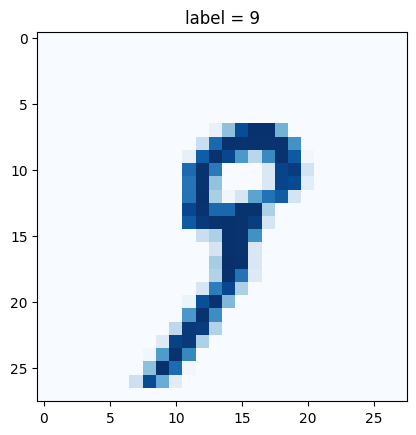

In [ ]:
mnist_dataset.plot_image(19)

### The Discriminator Class


In [5]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    #Create model
    self.model = nn.Sequential(
      nn.Linear(784, 200),
      nn.LeakyReLU(0.02),

      nn.LayerNorm(200),

      nn.Linear(200, 1),
      nn.Sigmoid())
    # create loss function
    self.loss_function = nn.BCELoss()

    # create optimiser, using stochastic gradient descent
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

    # counter and accumulator for progress
    self.counter = 0
    self.progress = []

  def forward(self,inputs):
    return self.model(inputs)

  def train(self,inputs,targets):
    # calculate the output of the network
    outputs = self.forward(inputs)

    # calculate loss
    loss = self.loss_function(outputs, targets)

    # increase counter and accumulate error every 10 epochs
    self.counter += 1
    if (self.counter % 10 == 0):
        self.progress.append(loss.item())
    if (self.counter % 10000 == 0):
        print("counter = ", self.counter)
        pass

    # zero gradients, perform a backward pass, update weights
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


It is a good idea to test the discriminator first before coupling it with the generator. This will tell us that the discriminator has the capacity to at least separate real data from random noise.

In [6]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data
print("Random noise pattern:", float(generate_random(7)[0]))

Random noise pattern: 0.45856595039367676


In [7]:
%%time
D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # real data
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(784), torch.FloatTensor([0.0]))

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 4min 28s, sys: 2.7 s, total: 4min 30s
Wall time: 4min 41s


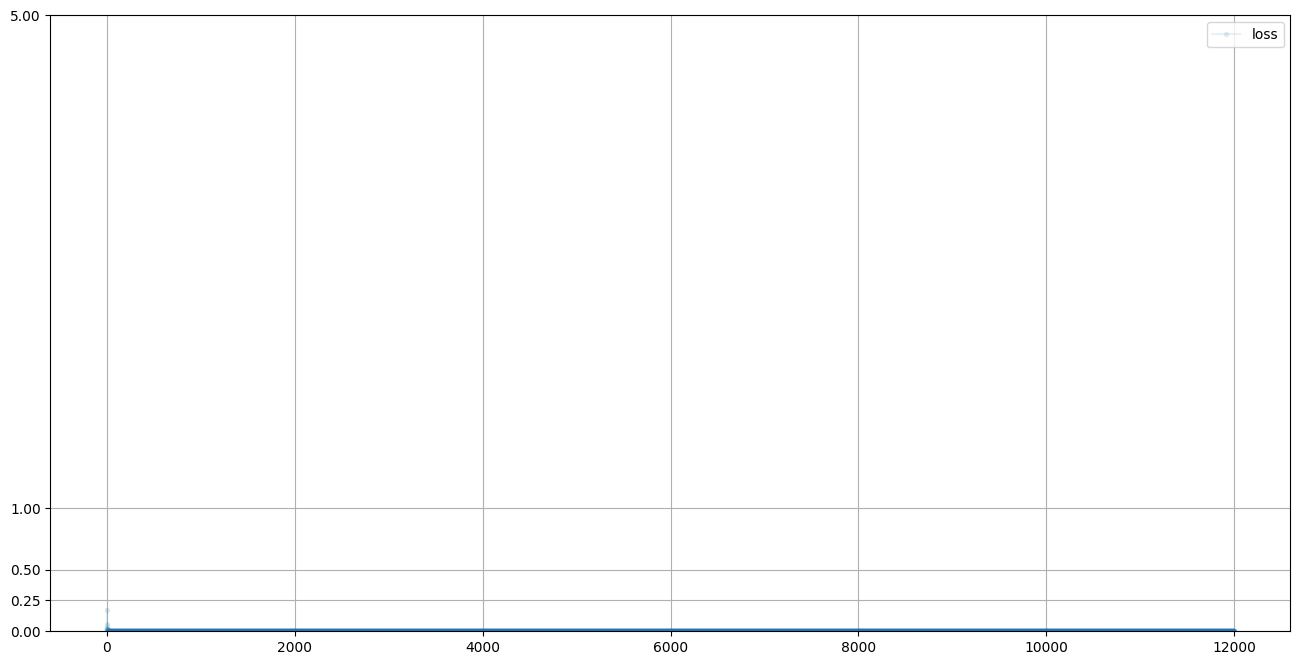

In [8]:
D.plot_progress()

In [9]:

# manually run discriminator to check it can tell real data from fake
import random
for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0,1000)][1]
  print( D.forward( image_data_tensor ).item() )

for i in range(4):

  x =  D.forward( generate_random(784))
  print(float(x[0]))


1.0
1.0
1.0
1.0
8.583017976904195e-12
1.1028298933790648e-11
9.892474860107026e-12
9.109899466730464e-12


We are not sure if this configuration would work for the GAN network but it does discriminate between real and fake examples.

In [10]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(100,200),
        nn.LeakyReLU(0.02),
        nn.LayerNorm(200),
        nn.Linear(200,784),
        nn.Sigmoid())
    self.optimizer = torch.optim.Adam(self.parameters(),lr = 0.0001)
    self.counter = 0
    self.progress =[]

  def forward(self,inputs):
    return self.model(inputs)

  def train(self,D,inputs,targets):
    g_out = self.forward(inputs)
    d_out = D.forward(g_out)
    loss = D.loss_function(d_out,targets)

    # increase counter and accumulate error every 10
    self.counter += 1
    if (self.counter % 10 == 0):
        self.progress.append(loss.item())
        pass

    # zero gradients, perform a backward pass, update weights
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

Training the generator is different from the discriminator because we do not have a separate Loss function. Generator learns from the backpropagated gradients of the discriminator, therefore the training function of the generator will use the loss of the discriminator.

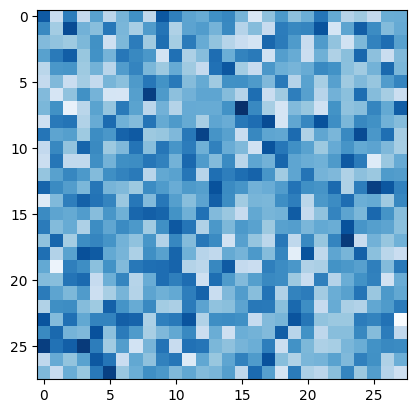

In [11]:
G = Generator()
output = G.forward(generate_random(100))
img = output.detach().numpy().reshape(28,28)
plt.imshow(img, interpolation='none', cmap='Blues')

In [12]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

The pattern isn’t in the form of a digit because the generator isn’t trained yet.

In [13]:
# create Discriminator and Generator
%%time
D = Discriminator()
G = Generator()

D = Discriminator()
G = Generator()

# train Discriminator and Generator

for label, image_data_tensor, target_tensor in mnist_dataset:

    # train discriminator on true
    D.train(image_data_tensor, torch.FloatTensor([1.0]))

    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))

    # train generator
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))




counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 8min 6s, sys: 4.05 s, total: 8min 10s
Wall time: 8min 15s


That detach() applied to the output of the generator detaches it from the computation graph. Normally, calling backwards() on the discriminator loss causes error gradients to be calculated all the way back along with the computation graph - from the discriminator loss, through the discriminator itself, and then back through the generator. Because we’re only training the discriminator, we don’t need to calculate the gradients for the generator. That detach() applied to the generator output cuts the computation graph at that point.

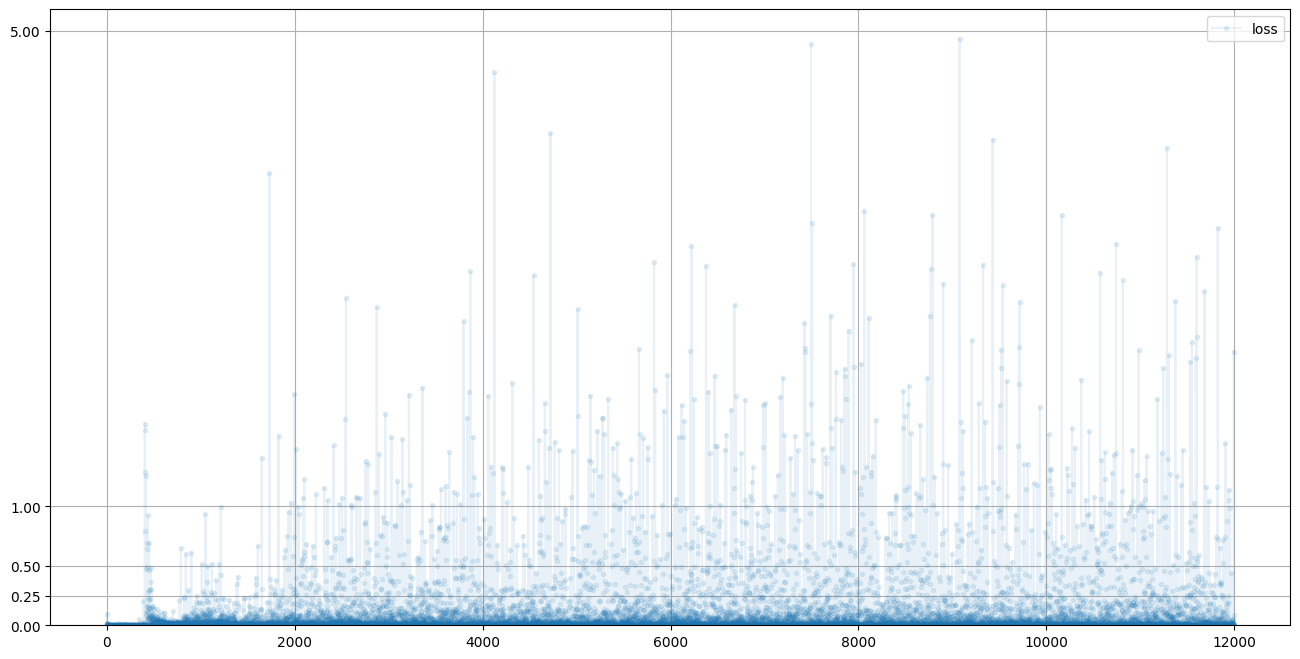

In [14]:
D.plot_progress()

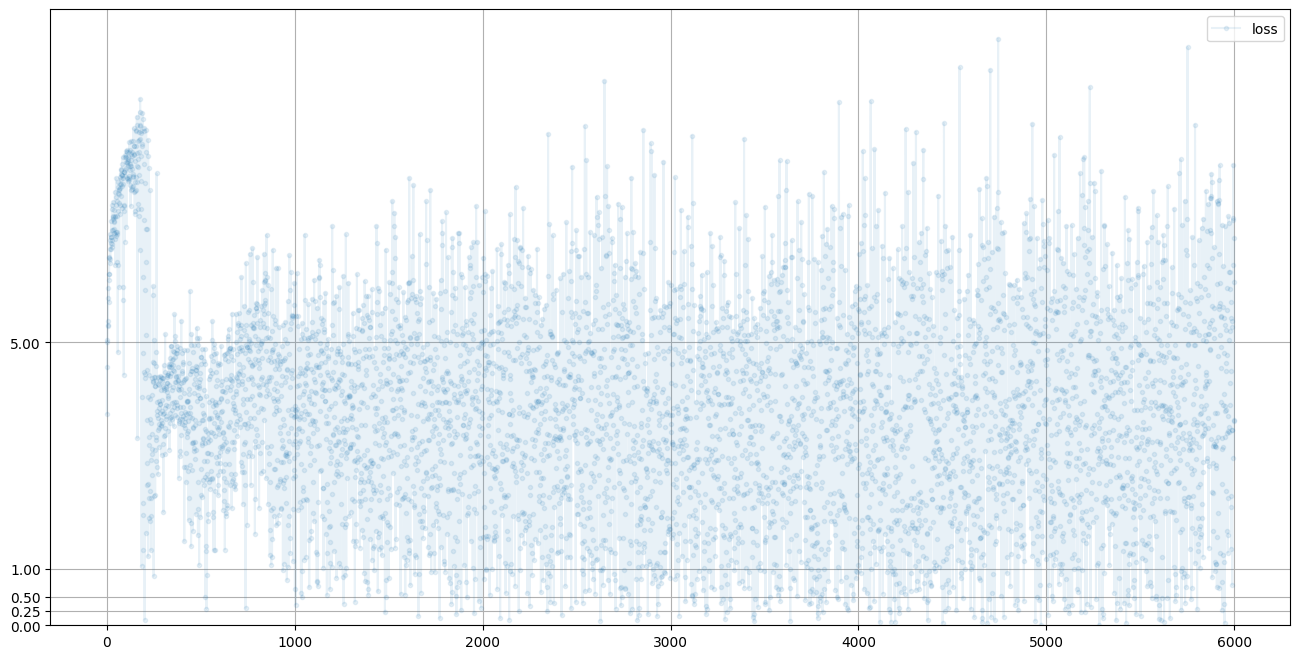

In [15]:
G.plot_progress()

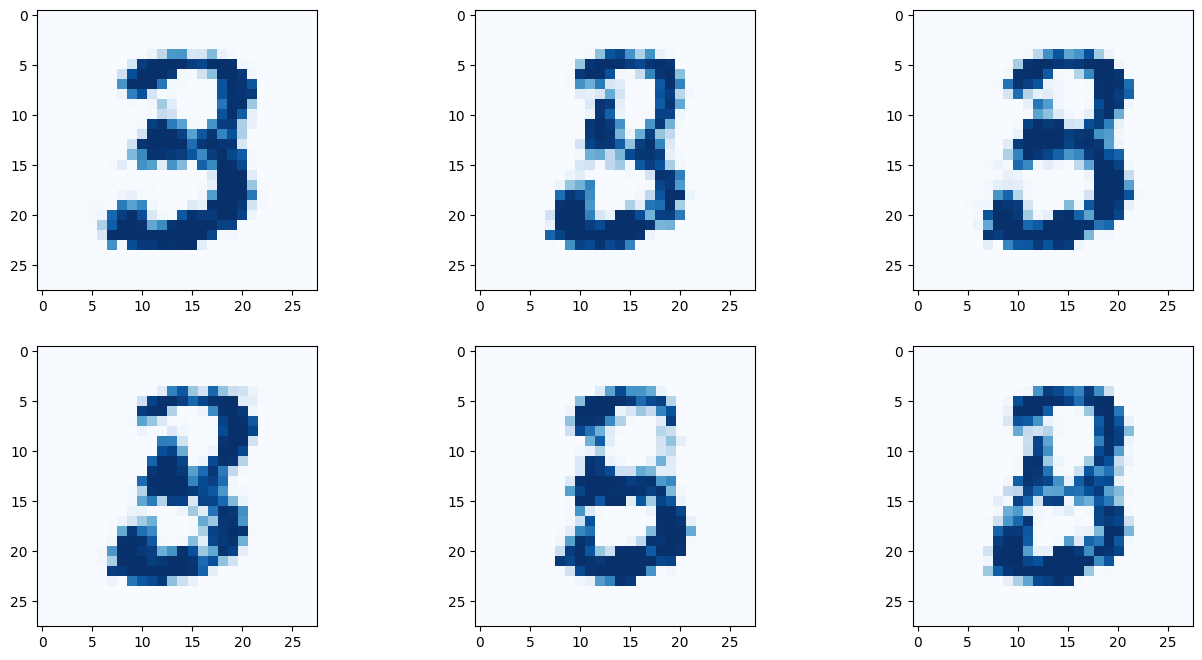

In [16]:
# check the generated output of Generator
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')


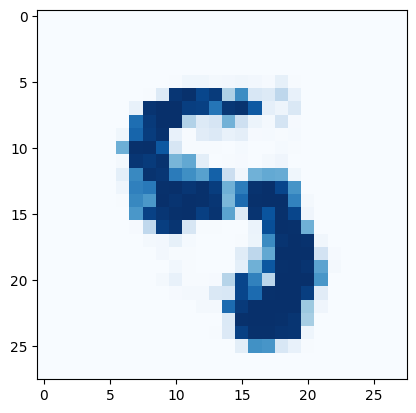

In [23]:
seed1 = generate_random_seed(100)
out1 = G.forward(seed1)
img1 = out1.detach().numpy().reshape(28,28)
plt.imshow(img1, interpolation='none', cmap='Blues')

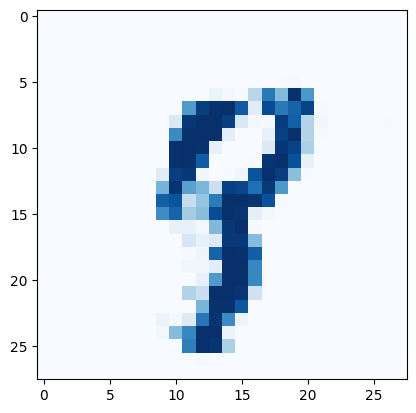

In [22]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out2.detach().numpy().reshape(28,28)
plt.imshow(img2, interpolation='none', cmap='Blues')

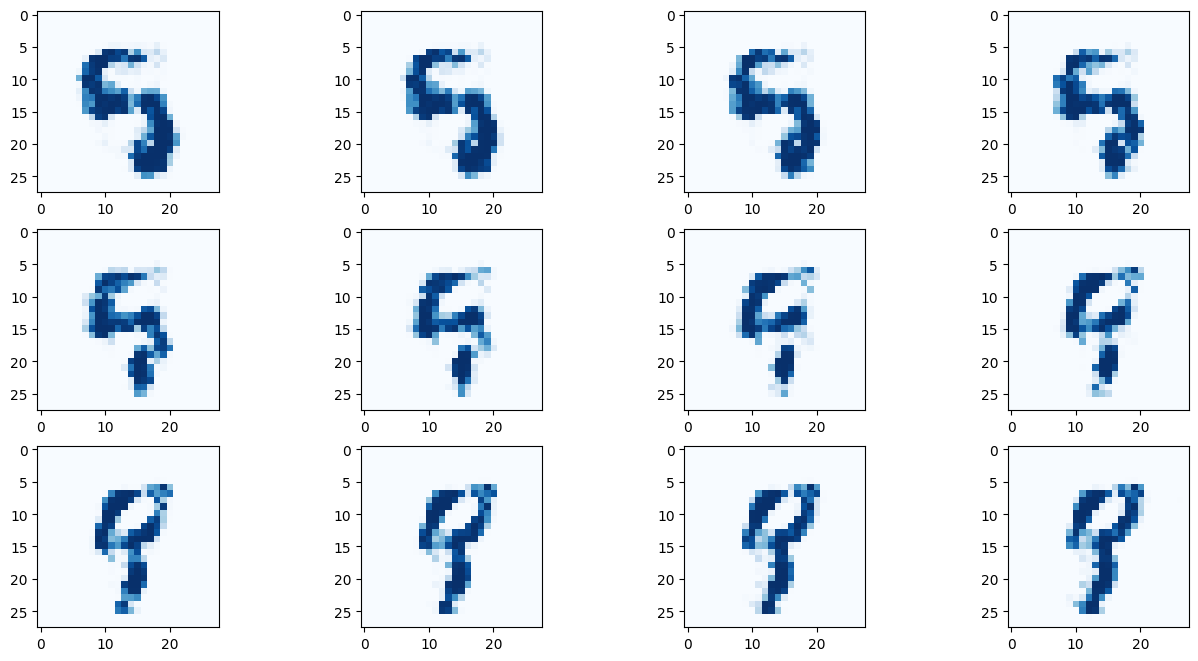

In [24]:
# plot several outputs from the trained generator

count = 0

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        seed = seed1 + (seed2 - seed1)/11 * count
        output = G.forward(seed)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        count = count + 1

This chart shows quite clearly how the generator improves over time. Initially the generator creates a rather indistinct pattern (the first column in the output). About half way through training, the generator suddenly is able to generate a 1010 pattern which continues to become clearer during the remainder of the training.

## Conclusion

A good pattern for developing and training a GAN includes the following steps.

1. Preview data from the real dataset.

2. Test the discriminator to see if it can at least learn to separate real data from random noise.

3. Test the untrained generator to see if it can create data of the right shape.

4. Visualize the loss values to understand how well training progressed.